# Settings
**SAMPLE_DURATION:** We went with 3 seconds, because its enough to get some sense of a beat, gives us room to oversample the underrepresented genres and librosa says that 2 seconds is not enough data for proper analysis. 

**SAMPLES_PER_GENRE:** The most common genre is rock without 179 beats and the least common is pop with only 20 beats (longer than 3 seconds). But pop has some really long audio files so we can sample them multiple times to get just as many samples as rock. Also there is nothing holding us back from just taking some more rock samples too. 

**SAMPLES PER_TRACK:** The long pop beats vary the beat in the audio file a lot, so its not just 1 beat in there. So taking multiple samples of them is ok, but still we dont want too many samples from the same file, because a risk of 1 beat dominating the genre exists. 

**MAX_OVERSAMPLING_RATIO:** A very long audio file can be reasonably sampled more often than a short one. This ratio limits how many seconds relative to the full duration of the audio we sample. 

**RANDOM_SEED:** We want to be able to reproduce the results, so we set a seed for the random number generator.

In [28]:
SAMPLE_DURATION = 3.0           # how long should a sample be?
SAMPLES_PER_GENRE = 200         # lets have this many samples for every genre
MAX_SAMPLES_PER_FILE = 25       # don't oversample 1 beat
MAX_OVERSAMPLING_RATIO = 0.5    # don't sample more than this ratio of the full duration of one file (data.duration * MAX_OVERSAMPLING_RATIO / SAMPLE_DURATION)
RANDOM_SEED = 2024              # keep it reproducible

# Processing

In [29]:
import pandas as pd

data = pd.read_csv('data_reduced.csv', encoding="latin-1")
data.head()

# only use beats longer than SAMPLE_DURATION, not fills
beat_mask = (data['beat_type'] == 1) & (data.duration >= SAMPLE_DURATION)
data = data[beat_mask]

In [30]:
data.columns

Index(['Unnamed: 0', 'drummer', 'session', 'id', 'style', 'simplified_style',
       'bpm', 'beat_type', 'time_signature', 'midi_filename', 'audio_filename',
       'duration', 'split', 'onset_env_mean', 'onset_env_std', 'mfcc_mean',
       'mfcc_std', 'spectral_flux_mean', 'spectral_flux_std',
       'spectral_contrast_mean', 'spectral_contrast_std', 'tonnetz_mean',
       'tonnetz_std', 'rms_mean', 'rms_std', 'spectral_centroid_mean',
       'spectral_centroid_std', 'spectral_bandwidth_mean',
       'spectral_bandwidth_std', 'spectral_flatness_mean',
       'spectral_flatness_std', 'tempogram_mean', 'tempogram_std'],
      dtype='object')

In [31]:
# all the features need to be recalculated for the sliced audio data, so we drop them
columns_to_drop = ['Unnamed: 0', 'onset_env_mean', 'onset_env_std', 'mfcc_mean',
       'mfcc_std', 'spectral_flux_mean', 'spectral_flux_std',
       'spectral_contrast_mean', 'spectral_contrast_std', 'tonnetz_mean',
       'tonnetz_std', 'rms_mean', 'rms_std', 'spectral_centroid_mean',
       'spectral_centroid_std', 'spectral_bandwidth_mean',
       'spectral_bandwidth_std', 'spectral_flatness_mean',
       'spectral_flatness_std', 'tempogram_mean', 'tempogram_std']

data = data.drop(columns_to_drop, axis=1)
print(data.simplified_style.value_counts())
data.describe()

simplified_style
rock      179
funk       82
latin      59
jazz       52
hiphop     34
pop        20
Name: count, dtype: int64


,bpm,beat_type,duration
count,426.000000,426.0,426.000000
mean,109.589202,1.0,86.707123
std,28.059731,0.0,84.930078
min,50.000000,1.0,3.031250
25%,93.000000,1.0,23.990625
50%,104.000000,1.0,54.098745
75%,120.000000,1.0,136.830771
max,290.000000,1.0,611.564048


In [32]:
data.bpm.mean()

109.58920187793427

In [33]:
import random
random.seed(RANDOM_SEED)

def pick_random_sample_out_of_area(area_start, area_end, duration):
    sample_start = round(random.uniform(area_start, area_end - duration), 3)
    sample_end = sample_start + duration
    return sample_start, sample_end

In [34]:
# Add start and end sample to the data. All original entries get the first 2 seconds of the audio file.
data[['start', 'end']] = data.apply(lambda x: pd.Series(pick_random_sample_out_of_area(0, x.duration, SAMPLE_DURATION)), axis=1)
data["times_sampled"] = 1
data.head()

,drummer,session,id,style,simplified_style,bpm,beat_type,time_signature,midi_filename,audio_filename,duration,split,start,end,times_sampled
0,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,funk,138,1,4-4,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,27.872308,test,11.692,14.692,1
1,drummer1,drummer1/eval_session,drummer1/eval_session/10,soul/groove10,funk,102,1,4-4,drummer1/eval_session/10_soul-groove10_102_bea...,drummer1/eval_session/10_soul-groove10_102_bea...,37.691158,test,25.264,28.264,1
2,drummer1,drummer1/eval_session,drummer1/eval_session/2,funk/groove2,funk,105,1,4-4,drummer1/eval_session/2_funk-groove2_105_beat_...,drummer1/eval_session/2_funk-groove2_105_beat_...,36.351218,test,10.130,13.130,1
3,drummer1,drummer1/eval_session,drummer1/eval_session/3,soul/groove3,funk,86,1,4-4,drummer1/eval_session/3_soul-groove3_86_beat_4...,drummer1/eval_session/3_soul-groove3_86_beat_4...,44.716543,test,37.015,40.015,1
4,drummer1,drummer1/eval_session,drummer1/eval_session/4,soul/groove4,funk,80,1,4-4,drummer1/eval_session/4_soul-groove4_80_beat_4...,drummer1/eval_session/4_soul-groove4_80_beat_4...,47.987500,test,18.449,21.449,1


In [35]:
def pick_area_to_sample(audio_filename):
    # get all samples of that file so far
    all_samples = pd.concat([data, new_samples_df])
    samples = all_samples[all_samples.audio_filename == audio_filename]
    
    if len(samples) == 0:
        print("No samples for", audio_filename)
        return None

    samples = samples.sort_values(by='start', ascending=True)
    
    # get all unused 'inbetween' areas, that are longer than 2 seconds
    if(samples.iloc[0].start > SAMPLE_DURATION):
        free_areas = [(0, samples.iloc[0].start)]
    else:
        free_areas = []
    
    for i in range(1, len(samples)):
        start_of_free_area = samples.iloc[i-1].end
        
        if i == len(samples) - 1:
            end_of_free_area = samples.iloc[i].duration
        else:
            end_of_free_area = samples.iloc[i].start
        
        if start_of_free_area + SAMPLE_DURATION < end_of_free_area:
            free_areas.append((start_of_free_area, end_of_free_area))
    
    # pick a random free area
    if len(free_areas) == 0:
        return None
    else:
        return free_areas[random.randint(0, len(free_areas)-1)]
    
#pick_area_to_sample(data.audio_filename[0])

In [36]:
def update_sampling_counter(dataframe, filename):
    filemask = dataframe.audio_filename == filename
    
    if(len(dataframe[filemask]) == 0):
        print("No samples for", filename)
        return
    
    dataframe.loc[(filemask), "possible_samples"] = dataframe.loc[(filemask), "possible_samples"] - 1.0
    dataframe.loc[(filemask), "times_sampled"] = dataframe.loc[(filemask), "times_sampled"] + 1

In [37]:
data["possible_samples"] = (data.duration / SAMPLE_DURATION) * MAX_OVERSAMPLING_RATIO
data.possible_samples = data.possible_samples - 1.0

# dataframe to save the new samples in
new_samples_df = pd.DataFrame(columns=data.columns)

for style in data.simplified_style.unique():
    style_count = len(data[data.simplified_style == style])
    
    while style_count < SAMPLES_PER_GENRE:
        # pick list of files that can still be sampled, but are not oversampled
        possible_files_to_sample = data[(data.simplified_style == style) & (data.possible_samples >= 1.0) & (data.times_sampled < MAX_SAMPLES_PER_FILE)]
        # from those pick the ones, that were sampled the least
        possible_files_to_sample = possible_files_to_sample[possible_files_to_sample.times_sampled == possible_files_to_sample.times_sampled.min()]
        
        # pick random file
        index = random.randint(0, len(possible_files_to_sample)-1)
        filename = possible_files_to_sample.iloc[index].audio_filename
        
        # pick an unused time area from that file
        unused_area = pick_area_to_sample(possible_files_to_sample.iloc[index].audio_filename)
        if(unused_area == None):
            data.loc[(data.audio_filename == filename), "possible_samples"] = -1.0
            new_samples_df.loc[(new_samples_df.audio_filename == filename), "possible_samples"] = -1.0
            # try another file, if no area was found
            continue
        
        # pick a random sample from the unused area
        new_sample = possible_files_to_sample.iloc[index].copy()
        new_sample.start = round(random.uniform(unused_area[0], unused_area[1] - SAMPLE_DURATION), 3)
        #new_sample.start = round(random.uniform(0, new_sample.duration - SAMPLE_DURATION), 3)
        new_sample.end = new_sample.start + SAMPLE_DURATION
        
        # add new entry to list
        new_samples_df = pd.concat([new_samples_df, new_sample.to_frame().T], ignore_index=True)
        
        # update the original dataframe
        update_sampling_counter(data, filename)
        # update all the new entries
        update_sampling_counter(new_samples_df, filename)
        
        style_count += 1

# add all new samples to the original dataframe
data = pd.concat([data, new_samples_df], ignore_index=True)

C:\Users\kevin\AppData\Local\Temp\ipykernel_1292\1494960973.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_samples = pd.concat([data, new_samples_df])


# Checks

#### Balanced data check:

In [38]:
print(data.simplified_style.value_counts())

simplified_style
funk      200
hiphop    200
pop       200
rock      200
latin     200
jazz      200
Name: count, dtype: int64


#### Oversampling check

In [39]:
data.drop_duplicates(subset='audio_filename').times_sampled.value_counts().sort_index()

times_sampled
1     185
2      57
3      80
4      44
5      29
6       3
7       5
8       2
9      11
10      4
14      1
23      2
24      3
Name: count, dtype: int64

Check if files, that are often sampled (times_sampled) have a long duration, so that it is okay to take lots of samples from them. 

In [40]:
data["oversampling_ratio"] = data.times_sampled * SAMPLE_DURATION / data.duration

In [41]:
# most sampled files
data.sort_values(by='times_sampled', ascending=False).drop_duplicates(subset='audio_filename').head(10)

,drummer,session,id,style,simplified_style,bpm,beat_type,time_signature,midi_filename,audio_filename,duration,split,start,end,times_sampled,possible_samples,oversampling_ratio
785,drummer7,drummer7/session2,drummer7/session2/80,country,pop,78,1,4-4,drummer7/session2/80_country_78_beat_4-4.mid,drummer7/session2/80_country_78_beat_4-4.wav,144.700364,train,70.524,73.524,24,0.116727,0.49758
770,drummer1,drummer1/session1,drummer1/session1/101,dance/disco,pop,120,1,4-4,drummer1/session1/101_dance-disco_120_beat_4-4...,drummer1/session1/101_dance-disco_120_beat_4-4...,207.572917,train,162.073,165.073,24,10.595486,0.346866
835,drummer1,drummer1/session2,drummer1/session2/10,country,pop,114,1,4-4,drummer1/session2/10_country_114_beat_4-4.mid,drummer1/session2/10_country_114_beat_4-4.wav,154.966071,train,4.07,7.07,24,1.827679,0.464618
882,drummer7,drummer7/session3,drummer7/session3/11,pop/soft,pop,83,1,4-4,drummer7/session3/11_pop-soft_83_beat_4-4.mid,drummer7/session3/11_pop-soft_83_beat_4-4.wav,138.644661,validation,131.642,134.642,23,0.107444,0.497675
883,drummer1,drummer1/session3,drummer1/session3/6,dance/disco,pop,120,1,4-4,drummer1/session3/6_dance-disco_120_beat_4-4.mid,drummer1/session3/6_dance-disco_120_beat_4-4.wav,225.941667,train,5.87,8.87,23,14.656945,0.305389
724,drummer7,drummer7/session2,drummer7/session2/96,pop,pop,142,1,4-4,drummer7/session2/96_pop_142_beat_4-4.mid,drummer7/session2/96_pop_142_beat_4-4.wav,85.468267,validation,5.082,8.082,14,0.244711,0.49141
613,drummer8,drummer8/session1,drummer8/session1/5,hiphop,hiphop,90,1,4-4,drummer8/session1/5_hiphop_90_beat_4-4.mid,drummer8/session1/5_hiphop_90_beat_4-4.wav,127.755619,train,65.886,68.886,10,11.292603,0.234823
633,drummer7,drummer7/session3,drummer7/session3/24,hiphop,hiphop,67,1,4-4,drummer7/session3/24_hiphop_67_beat_4-4.mid,drummer7/session3/24_hiphop_67_beat_4-4.wav,96.361899,test,62.124,65.124,10,6.060316,0.311326
632,drummer7,drummer7/session1,drummer7/session1/17,hiphop,hiphop,100,1,4-4,drummer7/session1/17_hiphop_100_beat_4-4.mid,drummer7/session1/17_hiphop_100_beat_4-4.wav,84.00125,train,15.233,18.233,10,4.000208,0.357138
390,drummer8,drummer8/session1,drummer8/session1/4,hiphop,hiphop,90,1,4-4,drummer8/session1/4_hiphop_90_beat_4-4.mid,drummer8/session1/4_hiphop_90_beat_4-4.wav,114.480613,train,46.255,49.255,10,9.080102,0.262053


In [42]:
# check if the oversampling ratio wasn't exceeded. (Exept for files that just were sampled once anyway)
data[(data.times_sampled > 1) & (data.oversampling_ratio > 0.5)].sort_values(by='oversampling_ratio', ascending=True).drop_duplicates(subset='audio_filename').head(10)

,drummer,session,id,style,simplified_style,bpm,beat_type,time_signature,midi_filename,audio_filename,duration,split,start,end,times_sampled,possible_samples,oversampling_ratio


#### Check overlapping samples
pick_area_to_sample() should insure that there is no overlap at all. I dont really get why there is still some overlap so there might be a hidden bug. Thats why I am doing all these checks. The method drops the sample distrubiton from 10% overlap to around 2% overlap. So it works somewhat and that is good enough.

In [43]:
# check_overlapping_samples
overlapping_samples = pd.DataFrame(columns=data.columns)
overlapping_count = 0
overlapping_seconds = 0

for filename in data.audio_filename.unique():
    samples = data[data.audio_filename == filename]
    samples = samples.sort_values(by='start', ascending=True)
    
    for i in range(1, len(samples)):
        if samples.iloc[i-1].end > samples.iloc[i].start:
            overlapping_count += 1
            overlapping_seconds = overlapping_seconds + (samples.iloc[i-1].end - samples.iloc[i].start)
            # add both samples to the list
            overlapping_samples = pd.concat([overlapping_samples, samples.iloc[i-1:i+1]], ignore_index=True)

print("Found", overlapping_count, "overlaps in samples accounting for a total of", overlapping_seconds, "overlapping seconds.")
print("That is", round(overlapping_seconds * 100/ (len(data) * SAMPLE_DURATION), 1), "% of the total audio data (", len(data) * SAMPLE_DURATION, "seconds).")
overlapping_samples.sort_values(by=['audio_filename', 'start']).head(8)

Found 33 overlaps in samples accounting for a total of 42.813 overlapping seconds.
That is 1.2 % of the total audio data ( 3600.0 seconds).


,drummer,session,id,style,simplified_style,bpm,beat_type,time_signature,midi_filename,audio_filename,duration,split,start,end,times_sampled,possible_samples,oversampling_ratio
0,drummer1,drummer1/session1,drummer1/session1/101,dance/disco,pop,120,1,4-4,drummer1/session1/101_dance-disco_120_beat_4-4...,drummer1/session1/101_dance-disco_120_beat_4-4...,207.572917,train,197.055,200.055,24,10.595486,0.346866
1,drummer1,drummer1/session1,drummer1/session1/101,dance/disco,pop,120,1,4-4,drummer1/session1/101_dance-disco_120_beat_4-4...,drummer1/session1/101_dance-disco_120_beat_4-4...,207.572917,train,197.285,200.285,24,10.595486,0.346866
2,drummer1,drummer1/session1,drummer1/session1/78,jazz/fast,jazz,290,1,4-4,drummer1/session1/78_jazz-fast_290_beat_4-4.mid,drummer1/session1/78_jazz-fast_290_beat_4-4.wav,105.048858,train,101.586,104.586,5,12.508143,0.142791
3,drummer1,drummer1/session1,drummer1/session1/78,jazz/fast,jazz,290,1,4-4,drummer1/session1/78_jazz-fast_290_beat_4-4.mid,drummer1/session1/78_jazz-fast_290_beat_4-4.wav,105.048858,train,102.004,105.004,5,12.508143,0.142791
4,drummer1,drummer1/session1,drummer1/session1/81,dance/breakbeat,hiphop,170,1,4-4,drummer1/session1/81_dance-breakbeat_170_beat_...,drummer1/session1/81_dance-breakbeat_170_beat_...,56.392619,train,44.945,47.945,9,0.39877,0.478786
5,drummer1,drummer1/session1,drummer1/session1/81,dance/breakbeat,hiphop,170,1,4-4,drummer1/session1/81_dance-breakbeat_170_beat_...,drummer1/session1/81_dance-breakbeat_170_beat_...,56.392619,train,45.986,48.986,9,0.39877,0.478786
6,drummer1,drummer1/session2,drummer1/session2/3,latin/chacarera,latin,118,1,4-4,drummer1/session2/3_latin-chacarera_118_beat_4...,drummer1/session2/3_latin-chacarera_118_beat_4...,98.963006,train,94.119,97.119,4,12.493834,0.121257
7,drummer1,drummer1/session2,drummer1/session2/3,latin/chacarera,latin,118,1,4-4,drummer1/session2/3_latin-chacarera_118_beat_4...,drummer1/session2/3_latin-chacarera_118_beat_4...,98.963006,train,95.491,98.491,4,12.493834,0.121257


#### Check impossible start / end values

In [44]:
# check if there are no negative start times
print(data.start.min())
print(len(data[data.start < 0]))

0.004
0


In [45]:
# check if there is no start time that is bigger than the duration
print(len(data[data.end > data.duration]))
print(len(data[data.start > data.duration - SAMPLE_DURATION]))

0
0


In [46]:
# check if there are no samples that are shorter than SAMPLE_DURATION
print(len(data[data.end < data.start]))
print(len(data[data.end - data.start != SAMPLE_DURATION]))

0
166


In [47]:
# check if these are just floating point errors
(data[data.end - data.start != SAMPLE_DURATION].end - data[data.end - data.start != SAMPLE_DURATION].start).value_counts()

3.0    32
3.0    27
3.0    24
3.0    22
3.0    18
3.0    13
3.0    12
3.0     9
3.0     5
3.0     2
3.0     1
3.0     1
Name: count, dtype: int64

#### Check uniqueness of samples

In [48]:
# check if no two start positions exist
duplicate_starts = data.start.value_counts()[data.start.value_counts().values > 1]
duplicate_starts

start
0.879     3
0.125     3
1.781     2
0.065     2
1.194     2
0.568     2
1.116     2
10.137    2
13.101    2
12.848    2
4.21      2
21.881    2
5.423     2
0.004     2
2.821     2
Name: count, dtype: int64

For random seeds 42 and 420 there is actually 1 duplicate start for the same file! I thought I coded it in a way, that this should be impossible, but i guess i didnt. We could just drop that one duplicate but random seed 2024 has no duplicates at all (and also least overlapping) so we just ride with that:

In [49]:
# check if the files with duplicate starts are the same
start_mask = False
for key in duplicate_starts.keys():
    start_mask |= (data.start == key)
data[start_mask].audio_filename.value_counts()

audio_filename
drummer3/session1/25_rock_120_beat_4-4.wav                   1
drummer3/session1/6_rock_105_beat_4-4.wav                    1
drummer1/session1/5_jazz-funk_116_beat_4-4.wav               1
drummer10/session1/1_jazz-swing_124_beat_4-4.wav             1
drummer1/session2/112_afrocuban-bembe_122_beat_4-4.wav       1
drummer1/session3/11_afrobeat_94_beat_4-4.wav                1
drummer3/session1/3_rock_105_beat_4-4.wav                    1
drummer7/session3/1_rock_60_beat_4-4.wav                     1
drummer7/session3/11_pop-soft_83_beat_4-4.wav                1
drummer1/eval_session/7_pop-groove7_138_beat_4-4.wav         1
drummer7/session1/16_hiphop_100_beat_4-4.wav                 1
drummer7/session1/38_hiphop_100_beat_4-4.wav                 1
drummer7/session2/92_hiphop_75_beat_4-4.wav                  1
drummer1/session1/80_dance-breakbeat_170_beat_4-4.wav        1
drummer8/eval_session/4_soul-groove4_80_beat_4-4.wav         1
drummer1/session1/239_funk-purdieshuffle

# Save CSV

In [50]:
#data.to_csv('data_balanced.csv', index=False)

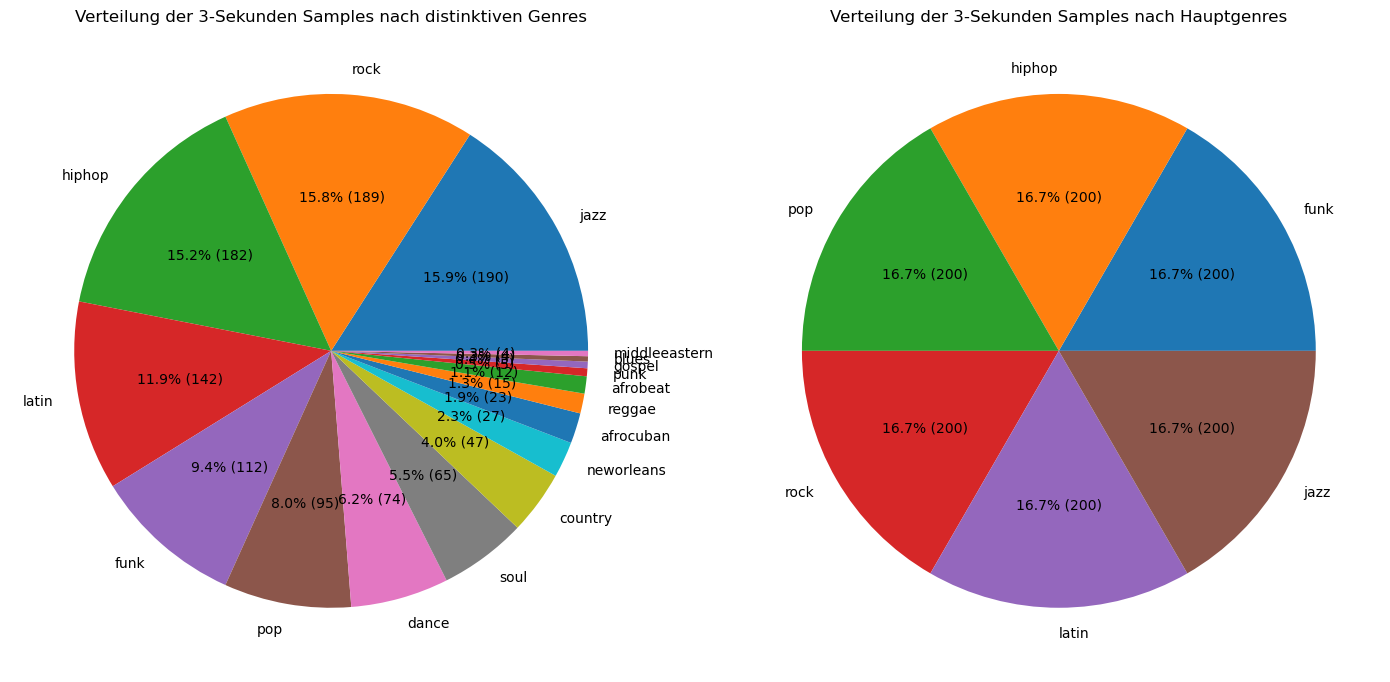

In [56]:
import matplotlib.pyplot as plt

def format_autopct(pct, total):
    return f"{pct:.1f}% ({int(pct/100 * total)})"

# Function to extract the main genres
def extract_main_genres(df, column):
    # Split the 'style' column by '/' and '-' and take the first element as the main genre
    df['main_genre'] = df[column].str.split(r'[/\-]').str[0]
    # Get the unique main genres
    main_genres = df['main_genre'].unique()
    return main_genres

# Extract the main genres from the 'style' column
main_genres = extract_main_genres(data, 'style')

# Filter and get value counts for 'main_genre' and 'simplified_style'
main_genres = data[data.beat_type == 1].main_genre.value_counts()
simplified_beats = data[data.beat_type == 1].simplified_style.value_counts()

# Create the subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot the first pie chart for main genres
main_genres.plot.pie(
    ax=axes[0],  # First subplot
    title='Verteilung der 3-Sekunden Samples nach distinktiven Genres',
    autopct=lambda pct: format_autopct(pct, main_genres.sum()),
    ylabel='',
)

# Plot the second pie chart for simplified styles
simplified_beats.plot.pie(
    ax=axes[1],  # Second subplot
    title='Verteilung der 3-Sekunden Samples nach Hauptgenres',
    autopct=lambda pct: format_autopct(pct, simplified_beats.sum()),
    ylabel='',
)

# Adjust layout so titles and labels don't overlap
plt.tight_layout()

# Show the combined plot
plt.show()